<a href="https://colab.research.google.com/github/raakhiM/classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Classification
# Scikit-Learn provides many helper functions to download popular datasets. MNIST is
# one of them. The following code fetches the MNIST dataset:


In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
import numpy as np

In [12]:
X,y = mnist["data"], mnist["target"]


In [13]:
X.shape

(70000, 784)

In [14]:
y.shape

(70000,)

In [15]:
# Let’s take a peek at one digit from the dataset. All you need to
# do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it
# using Matplotlib’s imshow() function:

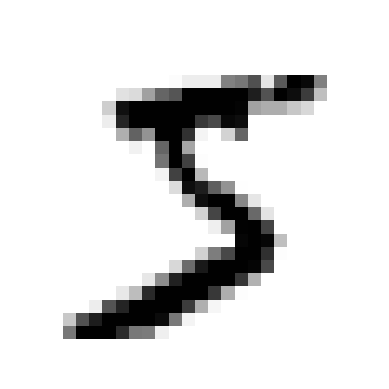

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
# Convert the pandas Series to a Numpy array before reshaping
some_digit_array = some_digit.values
some_digit_image = some_digit_array.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [17]:


y[0]

'5'

In [18]:
# The label is a string, so let's cast y to integers

In [19]:
y=y.astype(np.uint8)

In [20]:
# Let’s simplify the problem for now and only try to identify one digit—for example,
# the number 5. This “5-detector” will be an example of a binary classifier, capable of
# distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
# this classification task:


In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [23]:
# Let's take SGD classifier to train the data. This classifier has the advantage
# of handling large datasets efficiently
# This is because SGD deals with the training instances one at a time

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
# Now we can use it to detect images of the number 5
sgd_clf.predict([some_digit])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [26]:
# The following code does roughly the same thing as scikit learn's cross_val_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train.iloc[train_index]

In [27]:
# Let's use the cross-val-score to evaluate the sgd model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [28]:
# Above 93% accuracy (ratio of correct predictions) on all cross-validation folds?
# This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
# dumb classifier that just classifies every single image in the “not-5” class:

In [29]:

# To compute the confusion matrix, you first need to have a set of predictions so that
# they can be compared to the actual targets


In [30]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [31]:
# Just like the cross_val_score() function, cross_val_predict() performs K-fold
# cross-validation, but instead of returning the evaluation scores, it returns the predic‐
# tions made on each test fold

In [32]:

# Now you are ready to get the confusion matrix using the confusion_matrix() func‐
# tion. Just pass it the target classes (y_train_5) and the predicted classes
# (y_train_pred):

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

In [34]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [36]:
# Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
# When it claims an image represents a 5, it is correct only 72.9% of the time. More‐
# over, it only detects 75.6% of the 5s.

In [37]:
# To compute the F1 score, simply call the f1_score() function
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [38]:
# Scikit-Learn does not let you set the threshold directly, but it does give you access to
# the decision scores that it uses to make predictions. Instead of calling the classifier’s
# predict() method, you can call its decision_function() method, which returns a
# score for each instance, and then use any threshold you want to make predictions
# based on those scores:


y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [40]:
# The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
# result as the predict() method (i.e., True). Let’s raise the threshold:


In [41]:
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [42]:
# How do you decide which threshold to use? First, use the cross_val_predict()
# function to get the scores of all instances in the training set, but this time specify that
# you want to return decision scores instead of predictions:

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method ="decision_function")

In [44]:
# With these scores, use the precision_recall_curve() function to compute precision
# and recall for all possible thresholds:

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [46]:
# Finally use matplotlib to plot precision & recall as functions of the threshold value

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")


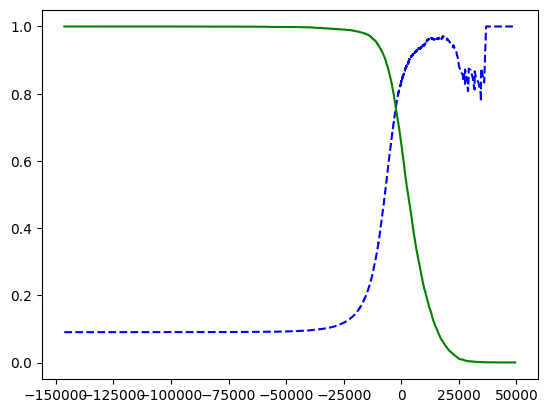

In [48]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [49]:
# Another way to select a good precision/recall trade-off is to plot precision directly
# against recall

In [50]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.9)]


In [51]:


# To make predictions(on the training set for now), instead of calling the classifier's predict() method, you can run this code
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [54]:
# If someone says, “Let’s reach 99% precision,” you should ask, “At
# what recall?”


In [55]:
# To plot the ROC curve, you first need to use the roc_curve() function to compute the
# FPR and TPR for various threshold values:

In [56]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

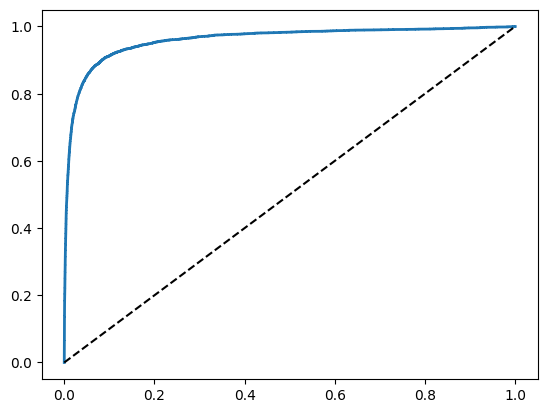

In [57]:
# Then you can plot the FPR against the TPR using the matplotlib
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # Dashed diagonal

plot_roc_curve(fpr,tpr)
plt.show()

In [58]:
# One way to compare classifiers is to measure the area under the curve (AUC). A per‐
# fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
# have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
# AUC:

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [60]:
# Let's now train a random forest classifier & compare its ROC curve & ROC AUC score to those of the SGDClassifier
# The random forest classifier does not have a decision_function() instead it has a predict_proba() method
# The predict_proba method returns an array containing a row per instance & a column per class, each containing the probability that
# the given instance belongs to the given class


In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# The roc_curve() function expects labels & scores, but instead of scores you can give it class probabilities
# Let's use the positive class's probability as the score

In [62]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


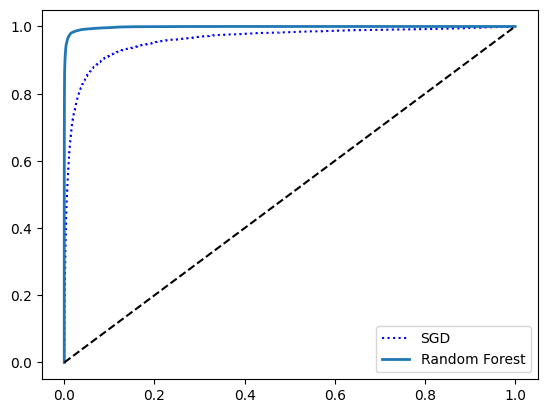

In [63]:
# Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [64]:
# As you can see, the random forest classifier's ROC curve looks much better than the SGDClassifiers
# It comes much closer to the top left corner, as a result its ROC AUC score is also significantly better

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [66]:
# Multi-Class classification
# Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
# class classification task, and it automatically runs OvR or OvO, depending on the
# algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5),
# using the sklearn.svm.SVC class:

In [67]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])
# This code trains the SVC on the training set using the original target
# classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
# (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
# Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
# decision scores for the image, and selected the class that won the most duels.
# If you call the decision_function() method, you will see that it returns 10 scores
# per instance (instead of just 1). That’s one score per class:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [68]:
# If you call the decision_function() method, you will see that it returns 10 scores per instance instead of just one
#  That's one score per class

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [69]:
# The highest score is indeed the one corresponding to class 5
np.argmax(some_digit_scores)



np.int64(5)

In [70]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [71]:
svm_clf.classes_[5]

np.uint8(5)

In [72]:
# If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
# can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an
# instance and pass a classifier to its constructor (it does not even have to be a binary
# classifier). For example, this code creates a multiclass classifier using the OvR strat‐
# egy, based on an SVC:

In [73]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

array([5], dtype=uint8)

In [74]:

len(ovr_clf.estimators_)

10

In [75]:
# Training an SGDClassifier or a Random Forest Classifier is just as easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
# directly classify instances into multiple classes. The decision_function() method
# now returns one value per class. Let’s look at the score that the SGD classifier assigned
# to each class:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [76]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [77]:
# Now of course you want to evaluate this
# classifier. As usual, you can use cross-validation. Use the cross_val_score() func‐
# tion to evaluate the SGDClassifier’s accuracy:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [78]:
# If you used a random classifier, you would get 10% accuracy, so this is not such a bad score
# Simply scaling the inputs increases accuracy above 89%

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [79]:
# Here we will assume that you have found a promising model & you want to find ways to improve it.
# One way to do this is to analyze the types of errors it makes

In [80]:
# First look at the confusion matrix
# You need to make predictions using the cross_val_predict function, then call the confusion_matrix()
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

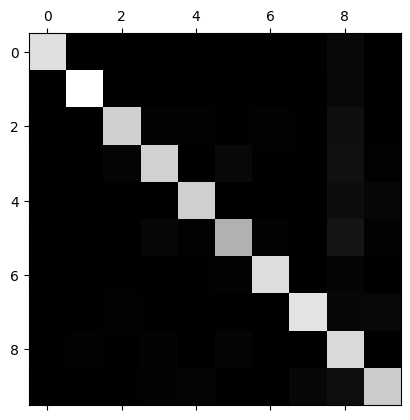

In [81]:
# That’s a lot of numbers. It’s often more convenient to look at an image representation
# of the confusion matrix, using Matplotlib’s matshow() function:

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [82]:
# This confusion matrix looks pretty good, since most images are on the main diago‐
# nal, which means that they were classified correctly. The 5s look slightly darker than
# the other digits, which could mean that there are fewer images of 5s in the dataset or
# that the classifier does not perform as well on 5s as on other digits.

In [83]:
# Let’s focus the plot on the errors. First, you need to divide each value in the confusion
# matrix by the number of images in the corresponding class so that you can compare
# error rates instead of absolute numbers of errors

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

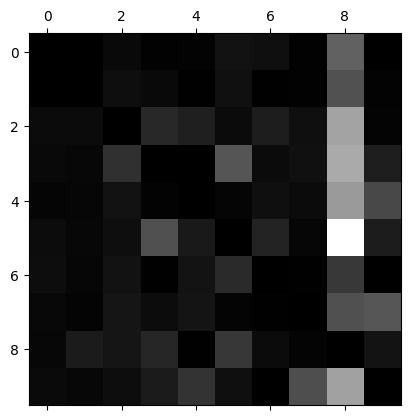

In [85]:
# Fill the diagonal with zeros to keep only the errors, and plot the result
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [86]:
# Analyzing the confusion matrix often gives you insights into ways to improve your
# classifier. Looking at this plot, it seems that your efforts should be spent on reducing
# the false 8s. For example, you could try to gather more training data for digits that
# look like 8s (but are not) so that the classifier can learn to distinguish them from real
# 8s. Or you could engineer new features that would help the classifier—for example,
# writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
# has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
# OpenCV) to make some patterns, such as closed loops, stand out more.

In [87]:
# Analyzing individual errors can also be a good way to gain insights on what your classifier is doing
# & why it is failing, but it is more difficult and time consuming
# For eg. lets plot examples of 3s and 5s

cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


In [88]:
# However, most misclassified images seem
# like obvious errors to us, and it’s hard to understand why the classifier made the mis‐
# takes it did.3
# The reason is that we used a simple SGDClassifier, which is a linear
# model. All it does is assign a weight per class to each pixel, and when it sees a new
# image it just sums up the weighted pixel intensities to get a score for each class. So
# since 3s and 5s differ only by a few pixels, this model will easily confuse them.


In [89]:
# If you draw a 3 with the junction slightly shifted to the left,
# the classifier might classify it as a 5, and vice versa. In other words, this classifier is
# quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion
# would be to preprocess the images to ensure that they are well centered and not too
# rotated. This will probably help reduce other errors as well

In [90]:
# Multi-Label Classification
# Until now each instance has always been assigned to just one class. In some cases you
# may want your classifier to output multiple classes for each instance.

In [91]:
# Consider a facerecognition classifier: what should it do if it recognizes several people in the same
# picture? It should attach one tag per person it recognizes. Say the classifier has been
# trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is
# shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes,
# Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is
# called a multilabel classification system.

In [92]:
# Let's look at a simple example
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [93]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [95]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [96]:
# This assumes that all labels are equally important, however, which may not be the
# case. In particular, if you have many more pictures of Alice than of Bob or Charlie,
# you may want to give more weight to the classifier’s score on pictures of Alice. One
# simple option is to give each label a weight equal to its support (i.e., the number of
# instances with that target label). To do this, simply set average="weighted" in the
# preceding code.

In [97]:
# MULTI-OUTPUT CLASSIFICATION
# It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have
#more than two possible values)

In [98]:
# Let’s start by creating the training and test sets by taking the MNIST images and
# adding noise to their pixel intensities with NumPy’s randint() function. The target
# images will be the original images:

In [99]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [100]:
# On the left is the noisy input image, and on the right is the clean target image. Now
# let’s train the classifier and make it clean this image:

In [1]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)

NameError: name 'knn_clf' is not defined

In [ ]:
# Looks close enough to the target! This concludes our tour of classification. You
# should now know how to select good metrics for classification tasks, pick the appro‐
# priate precision/recall trade-off, compare classifiers, and more generally build good
# classification systems for a variety of tasks.